<a href="https://colab.research.google.com/github/zubao-fitti/redes_neurais/blob/master/Gesture_Recognition_Redes_Neurais_Mateus_Fittipaldi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carrega a base de dados

In [ ]:
!git clone https://github.com/zubao-fitti/redes_neurais.git

Cloning into 'redes_neurais'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 22 (delta 0), reused 1 (delta 0), pack-reused 21
Unpacking objects: 100% (22/22), done.


Importa as bibliotecas

In [ ]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from zipfile import ZipFile
from PIL import Image

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


Função para definir as classes do dataset

In [ ]:
def data_class(x):
    switcher = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        '6': 6,
        '7': 7,
        '8': 8,
        '9': 9,
        'a': 10,
        'b': 11,
        'c': 12,
        'd': 13,
        'e': 14,
        'f': 15,
        'g': 16,
        'h': 17,
        'i': 18,
        'j': 19,
        'k': 20,
        'l': 21,
        'm': 22,
        'n': 23,
        'o': 24,
        'p': 25,
        'q': 26,
        'r': 27,
        's': 28,
        't': 29,
        'u': 30,
        'v': 31,
        'w': 32,
        'x': 33,
        'y': 34,
        'z': 35
        }
    return switcher.get(x, 'Label inválido')

Coletando os dados e separando em imagens e labels

In [ ]:
imgs_file = []
labels_data = []

file_1 = ZipFile('redes_neurais/Gesture_Recognition/handgesturedataset_part1.zip')
file_2 = ZipFile('redes_neurais/Gesture_Recognition/handgesturedataset_part2.zip')
file_3 = ZipFile('redes_neurais/Gesture_Recognition/handgesturedataset_part3.zip')
file_4 = ZipFile('redes_neurais/Gesture_Recognition/handgesturedataset_part4.zip')
file_5 = ZipFile('redes_neurais/Gesture_Recognition/handgesturedataset_part5.zip')

for entry in file_1.infolist():
    with file_1.open(entry) as file:
        img = Image.open(file)
        # test with less entries
        #dc = data_class(file.name[31])
        #if (dc < 10) :
        imgs_file.append(img)
        labels_data.append(data_class(file.name[31]))

for entry in file_2.infolist():
    with file_2.open(entry) as file:
        img = Image.open(file)
        # test with less entries
        #dc = data_class(file.name[31])
        #if (dc < 10) :
        imgs_file.append(img)
        labels_data.append(data_class(file.name[31]))

for entry in file_3.infolist():
    with file_3.open(entry) as file:
        img = Image.open(file)
        # test with less entries
        #dc = data_class(file.name[31])
        #if (dc < 10) :
        imgs_file.append(img)
        labels_data.append(data_class(file.name[31]))

for entry in file_4.infolist():
    with file_4.open(entry) as file:
        img = Image.open(file)
        # test with less entries
        #dc = data_class(file.name[31])
        #if (dc < 10) :
        imgs_file.append(img)
        labels_data.append(data_class(file.name[31]))

for entry in file_5.infolist():
    with file_5.open(entry) as file:
        img = Image.open(file)
        # test with less entries
        #dc = data_class(file.name[31])
        #if (dc < 10) :
        imgs_file.append(img)
        labels_data.append(data_class(file.name[31]))                           

In [ ]:
print(len(labels_data))

2515


Parâmetros iniciais

In [ ]:
RANDOM_SEED = 42
LEARNING_RATE = 0.005
# default is 32
BATCH_SIZE = 32
N_EPOCHS = 30

N_TRAIN_SIZE = int(np.around(len(labels_data) * 0.8))
N_VALID_SIZE = len(labels_data) - N_TRAIN_SIZE

# testing with less classes
N_CLASSES = 36


Classe para o dataset das imagens de gestos

In [ ]:
class GesturesDataset(Dataset):

    def __init__(self, image_files, data, transform=None):
        self.image_files = image_files
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.image_files[index]
        label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return (image, label)

Função para calcular a acurácia e para plotar o gráfico da taxa de perda

In [ ]:
def get_accuracy(model, data_loader, device):
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

def plot_accuracy(train_accuracy, valid_accuracy):
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_accuracy = np.array(train_accuracy) 
    valid_accuracy = np.array(valid_accuracy)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_accuracy, color='blue', label='Training accuracy') 
    ax.plot(valid_accuracy, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

# Redes Neurais

LeNet-5

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1) #transforma a matrix x em vetor.
        out = self.classifier(x)
        probs = F.softmax(out, dim=1)
        return out, probs

Mini-VGG

In [ ]:
class VGG_mini(nn.Module):

    def __init__(self, n_classes):
        super(VGG_mini, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),        
            nn.Linear(64, n_classes)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, 512 * 4 * 4)
        out = self.classifier(x)
        probs = F.softmax(out, dim=1)
        return out, probs

AlexNet

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, n_classes):
        super(AlexNet, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=4096, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, 256 * 6 * 6)
        out = self.classifier(x)
        probs = F.softmax(out, dim=1)
        return out, probs

# Algoritmos

Treinamento

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

Validação

In [ ]:
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

Loop de execução do treinamento

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
        
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accuracy = []
    valid_accuracy = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accuracy.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accuracy.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    plot_accuracy(train_accuracy, valid_accuracy)
    
    return model, optimizer, (train_losses, valid_losses)

# Execução das redes neurais

Faz as transformações necessárias e prepara o conjunto de treino e de validação para as redes neurais LeNet-5 e Mini-VGG

In [ ]:
# define transforms
transforms_ = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# create datasets
dset = GesturesDataset(imgs_file, labels_data, transform=transforms_)

train_dataset, valid_dataset = torch.utils.data.random_split(dset, [N_TRAIN_SIZE, N_VALID_SIZE])

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [ ]:
# show an image with label as test
def show_image(image, label, dataset):
    print(f"Label: {label}") 
    plt.imshow(image.permute(1,2,0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 20


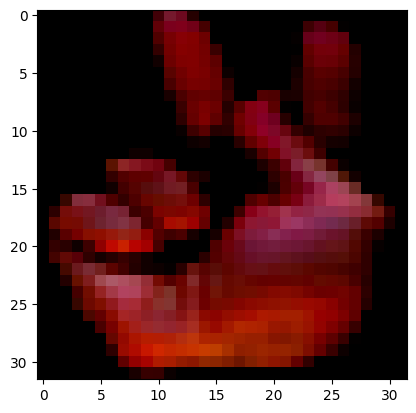

In [ ]:
show_image(*train_dataset[0], train_dataset)

Faz as transformações necessárias e prepara o conjunto de treino e de validação para a rede neural AlexNet

In [ ]:
# define transforms
transforms_ = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# create datasets
dset = GesturesDataset(imgs_file, labels_data, transform=transforms_)

train_dataset_an, valid_dataset_an = torch.utils.data.random_split(dset, [N_TRAIN_SIZE, N_VALID_SIZE])

# define the data loaders
train_loader_an = DataLoader(dataset=train_dataset_an, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader_an = DataLoader(dataset=valid_dataset_an, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 23


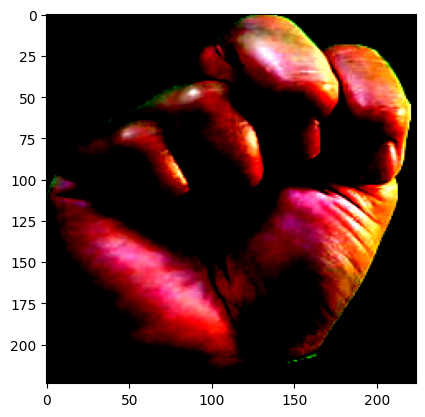

In [ ]:
show_image(*train_dataset_an[0], train_dataset_an)

LeNet-5

19:55:38 --- Epoch: 0	Train loss: 1.9364	Valid loss: 0.7774	Train accuracy: 72.32	Valid accuracy: 71.17
19:55:43 --- Epoch: 1	Train loss: 0.6605	Valid loss: 0.7264	Train accuracy: 75.60	Valid accuracy: 73.56
19:55:48 --- Epoch: 2	Train loss: 0.4210	Valid loss: 0.2777	Train accuracy: 91.50	Valid accuracy: 90.66
19:55:53 --- Epoch: 3	Train loss: 0.3234	Valid loss: 0.2797	Train accuracy: 90.36	Valid accuracy: 88.27
19:55:57 --- Epoch: 4	Train loss: 0.2255	Valid loss: 0.2145	Train accuracy: 92.84	Valid accuracy: 92.05
19:56:02 --- Epoch: 5	Train loss: 0.3027	Valid loss: 0.3012	Train accuracy: 91.50	Valid accuracy: 90.46
19:56:07 --- Epoch: 6	Train loss: 0.2260	Valid loss: 0.2399	Train accuracy: 93.69	Valid accuracy: 92.05
19:56:12 --- Epoch: 7	Train loss: 0.2646	Valid loss: 0.2717	Train accuracy: 93.64	Valid accuracy: 89.86
19:56:16 --- Epoch: 8	Train loss: 0.1527	Valid loss: 0.3599	Train accuracy: 93.44	Valid accuracy: 89.46
19:56:21 --- Epoch: 9	Train loss: 0.2316	Valid loss: 0.2276	Trai

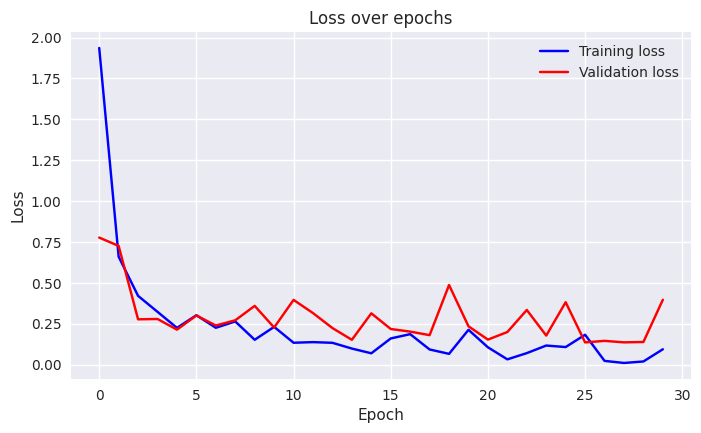

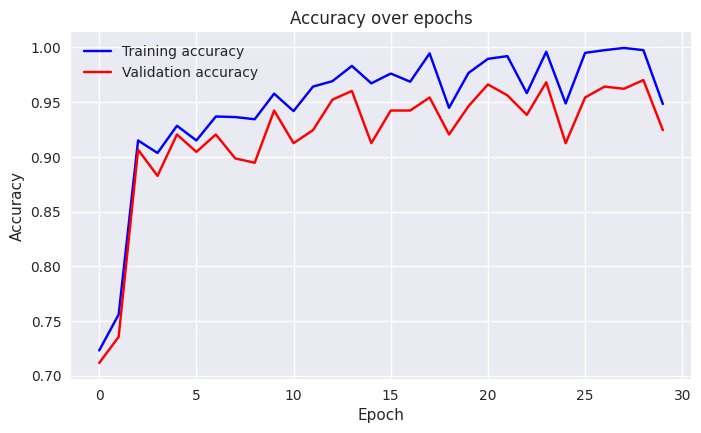

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

Mini-VGG

19:58:04 --- Epoch: 0	Train loss: 2.2027	Valid loss: 1.1031	Train accuracy: 64.12	Valid accuracy: 59.05
19:58:10 --- Epoch: 1	Train loss: 1.0991	Valid loss: 0.7363	Train accuracy: 74.90	Valid accuracy: 72.76
19:58:17 --- Epoch: 2	Train loss: 0.7397	Valid loss: 0.4459	Train accuracy: 87.23	Valid accuracy: 83.30
19:58:24 --- Epoch: 3	Train loss: 0.5308	Valid loss: 0.3396	Train accuracy: 88.67	Valid accuracy: 88.67
19:58:30 --- Epoch: 4	Train loss: 0.4925	Valid loss: 0.4146	Train accuracy: 85.88	Valid accuracy: 84.49
19:58:37 --- Epoch: 5	Train loss: 0.3852	Valid loss: 0.3670	Train accuracy: 89.76	Valid accuracy: 86.08
19:58:44 --- Epoch: 6	Train loss: 0.4116	Valid loss: 0.2872	Train accuracy: 91.80	Valid accuracy: 88.67
19:58:51 --- Epoch: 7	Train loss: 0.3086	Valid loss: 0.2014	Train accuracy: 94.09	Valid accuracy: 91.05
19:58:57 --- Epoch: 8	Train loss: 0.2762	Valid loss: 0.2345	Train accuracy: 92.45	Valid accuracy: 88.87
19:59:04 --- Epoch: 9	Train loss: 0.2398	Valid loss: 0.2413	Trai

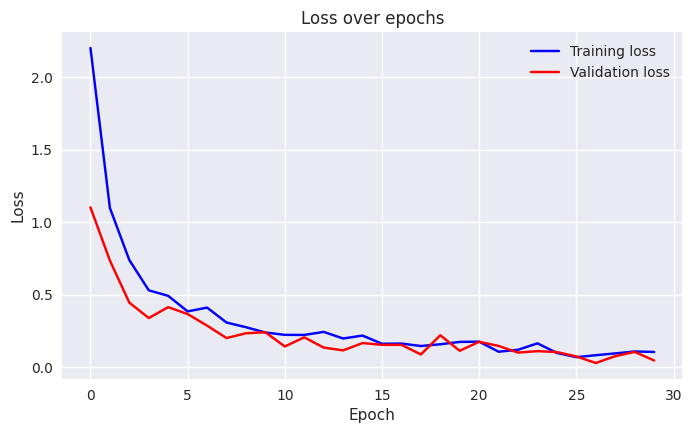

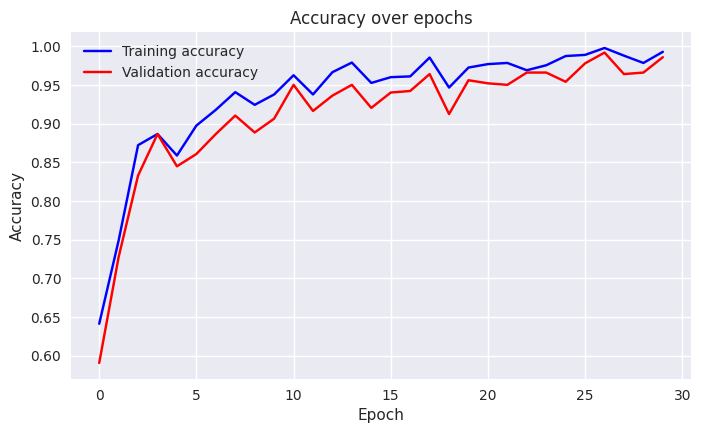

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = VGG_mini(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

AlexNet

20:51:24 --- Epoch: 0	Train loss: 326.9649	Valid loss: 3.5885	Train accuracy: 3.13	Valid accuracy: 1.39
20:51:38 --- Epoch: 1	Train loss: 3.5844	Valid loss: 3.5913	Train accuracy: 3.13	Valid accuracy: 1.39
20:51:51 --- Epoch: 2	Train loss: 3.5840	Valid loss: 3.5925	Train accuracy: 3.13	Valid accuracy: 1.39
20:52:04 --- Epoch: 3	Train loss: 3.5838	Valid loss: 3.5938	Train accuracy: 3.13	Valid accuracy: 1.39
20:52:17 --- Epoch: 4	Train loss: 3.5836	Valid loss: 3.5962	Train accuracy: 3.13	Valid accuracy: 1.39
20:52:30 --- Epoch: 5	Train loss: 3.5836	Valid loss: 3.5974	Train accuracy: 3.13	Valid accuracy: 1.39
20:52:44 --- Epoch: 6	Train loss: 3.5834	Valid loss: 3.5976	Train accuracy: 3.13	Valid accuracy: 1.39
20:52:57 --- Epoch: 7	Train loss: 3.5834	Valid loss: 3.5982	Train accuracy: 3.13	Valid accuracy: 1.39
20:53:10 --- Epoch: 8	Train loss: 3.5836	Valid loss: 3.5990	Train accuracy: 3.13	Valid accuracy: 1.39
20:53:23 --- Epoch: 9	Train loss: 3.5835	Valid loss: 3.5990	Train accuracy: 3.13

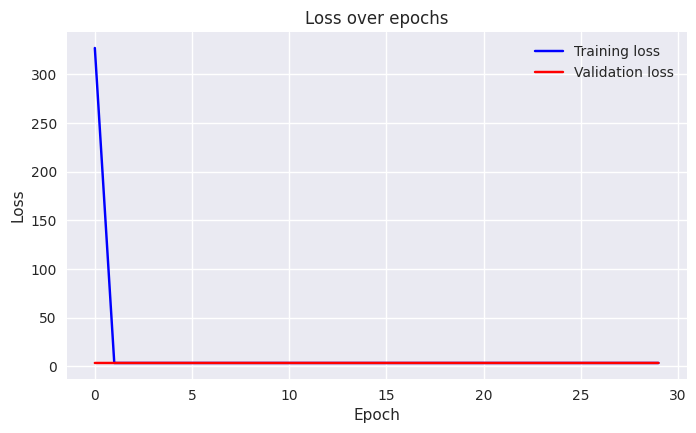

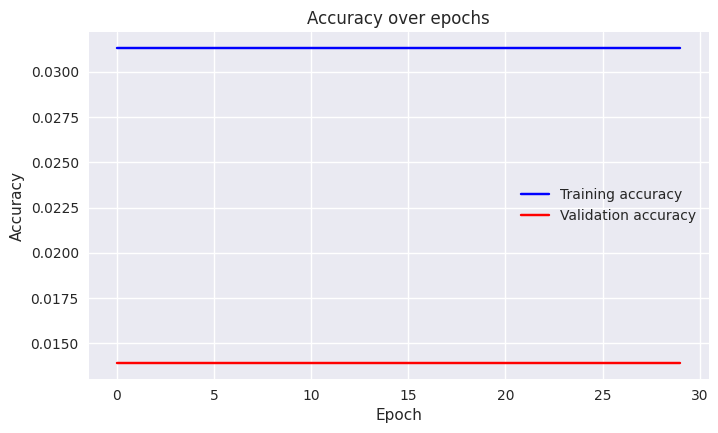

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader_an, valid_loader_an, N_EPOCHS, DEVICE)